### Clase 3: Laboratorio

In [4]:
import os
import shutil
local_nltk_path = os.path.join(os.getcwd(), "nltk_data")
shutil.rmtree(local_nltk_path, ignore_errors=True)
os.makedirs(local_nltk_path, exist_ok=True)
import nltk
nltk.data.path.clear()
nltk.data.path.append(local_nltk_path)
nltk.download('punkt', download_dir=local_nltk_path)
nltk.download('punkt_tab', download_dir=local_nltk_path)
nltk.download('perluniprops', download_dir=local_nltk_path)
nltk.download('nonbreaking_prefixes', download_dir=local_nltk_path)
from collections import defaultdict, Counter
import random
import math

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/fdiazja/Documents/work/classes/especialidad-en-
[nltk_data]     GenAI/Clase 3/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/fdiazja/Documents/work/classes/especialidad-en-
[nltk_data]     GenAI/Clase 3/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package perluniprops to
[nltk_data]     /Users/fdiazja/Documents/work/classes/especialidad-en-
[nltk_data]     GenAI/Clase 3/nltk_data...
[nltk_data]   Unzipping misc/perluniprops.zip.
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /Users/fdiazja/Documents/work/classes/especialidad-en-
[nltk_data]     GenAI/Clase 3/nltk_data...
[nltk_data]   Unzipping corpora/nonbreaking_prefixes.zip.


In [8]:
# Sample corpus in Spanish
corpus = """
El gato se sentó en la alfombra. El perro se sentó en el tronco. El gato y el perro son amigos.
María tiene un gato llamado Tomás que le gusta dormir en la alfombra.
Los perros generalmente prefieren los espacios abiertos como los parques.
Ana y Juan pasean a sus perros todas las mañanas antes del desayuno.
El clima estaba soleado y los niños jugaban con sus mascotas en el jardín.
Un gato curioso se subió al tejado y observó todo desde arriba.
La tienda de mascotas vende comida, juguetes y ropa para perros y gatos.
"""

# Normalize and tokenize corpus
import unicodedata
import string

def normalize_text(text, remove_punctuation=False):
    text = ''.join(c for c in unicodedata.normalize('NFD', text)
                   if unicodedata.category(c) != 'Mn')
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))
    return text

cleaned_corpus = normalize_text(corpus, remove_punctuation=False)
tokens = nltk.word_tokenize(cleaned_corpus.lower(), language='spanish')
vocab = set(tokens)

# Function to generate N-grams
def generate_ngrams(tokens, N):
    return [tuple(tokens[i:i+N]) for i in range(len(tokens)-N+1)]

# N-gram frequency computation
N = 2  # You can change this value to any N
grams = generate_ngrams(tokens, N)
ngram_freq = Counter(grams)
prefix_freq = Counter([gram[:-1] for gram in grams])

# N-gram probability with Laplace smoothing
def ngram_prob_smoothed(prefix, word):
    prefix = tuple(prefix)
    return (ngram_freq[prefix + (word,)] + 1) / (prefix_freq[prefix] + len(vocab))

# Predict next word using smoothed N-gram probabilities
def predict_next_ngram(context):
    context = context[-(N-1):]  # ensure correct context length
    candidates = {w: ngram_prob_smoothed(context, w) for w in vocab}
    return max(candidates, key=candidates.get)

print(f"Next word after ['el', 'gato']: {predict_next_ngram(['el', 'gato'])}")

Next word after ['el', 'gato']: y


Most likely POS tags: ['Articulo', 'Sustantivo', 'Verbo', 'Puntuacion', 'Articulo', 'Sustantivo', 'Verbo', 'Puntuacion', 'Articulo', 'Sustantivo', 'Verbo', 'Puntuacion']
POS Prediction for new sentence:
[('el', 'Articulo'), ('gato', 'Sustantivo'), ('juega', 'Verbo'), ('.', 'Puntuacion')]


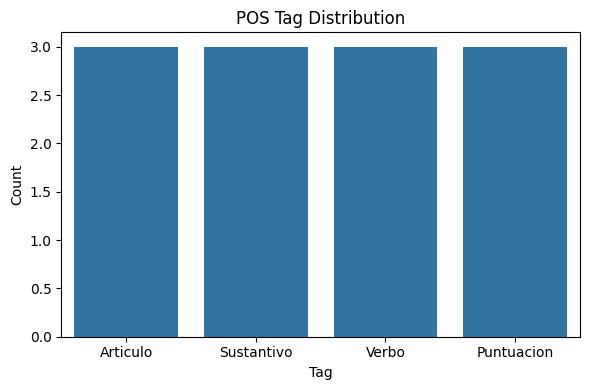

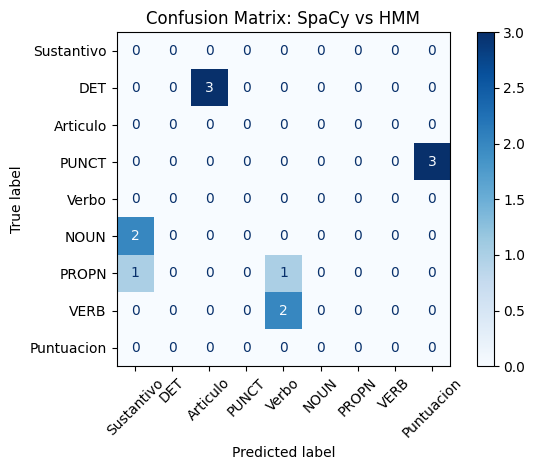

In [11]:
# --- 2. HIDDEN MARKOV MODELS ---

# Simple HMM POS tagging on a toy corpus

observations = ['el', 'gato', 'duerme', '.', 'la', 'niña', 'juega', '.', 'el', 'perro', 'ladra', '.']
states = ['Articulo', 'Sustantivo', 'Verbo', 'Puntuacion']

start_prob = {
    'Articulo': 0.5,
    'Sustantivo': 0.2,
    'Verbo': 0.2,
    'Puntuacion': 0.1
}

trans_prob = {
    'Articulo': {'Sustantivo': 0.6, 'Verbo': 0.1, 'Puntuacion': 0.1, 'Articulo': 0.2},
    'Sustantivo': {'Verbo': 0.6, 'Puntuacion': 0.3, 'Articulo': 0.1},
    'Verbo': {'Puntuacion': 0.8, 'Articulo': 0.2},
    'Puntuacion': {'Articulo': 1.0}
}

emiss_prob = {
    'Articulo': {'el': 0.6, 'la': 0.4},
    'Sustantivo': {'gato': 0.3, 'niña': 0.3, 'perro': 0.4},
    'Verbo': {'duerme': 0.3, 'juega': 0.3, 'ladra': 0.4},
    'Puntuacion': {'.': 1.0}
}

# Viterbi Algorithm
def viterbi(obs, states, start_p, trans_p, emit_p):
    V = [{}]
    path = {}
    for s in states:
        V[0][s] = math.log(start_p[s]) + math.log(emit_p[s].get(obs[0], 1e-6))
        path[s] = [s]

    for t in range(1, len(obs)):
        V.append({})
        new_path = {}
        for curr in states:
            (prob, prev) = max(
                (
                    V[t - 1][s] + math.log(trans_p[s].get(curr, 1e-6)) + math.log(emit_p[curr].get(obs[t], 1e-6)),
                    s
                ) for s in states
            )
            V[t][curr] = prob
            new_path[curr] = path[prev] + [curr]
        path = new_path

    (prob, final_state) = max((V[-1][s], s) for s in states)
    return math.exp(prob), path[final_state]

prob, tags = viterbi(observations, states, start_prob, trans_prob, emiss_prob)
print("Most likely POS tags:", tags)

def predict_pos(sentence):
    tokens = nltk.word_tokenize(sentence.lower(), language='spanish')
    prob, tags = viterbi(tokens, states, start_prob, trans_prob, emiss_prob)
    return list(zip(tokens, tags))

# Example usage
new_sentence = "el gato juega ."
print("POS Prediction for new sentence:")
print(predict_pos(new_sentence))

# Follow-up exercise: visualize tag distribution
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pos_counts = Counter(tags)
plt.figure(figsize=(6, 4))
sns.barplot(x=list(pos_counts.keys()), y=list(pos_counts.values()))
plt.title("POS Tag Distribution")
plt.xlabel("Tag")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Optional: Compare with SpaCy POS tagging if installed
try:
    import spacy
    nlp = spacy.load("es_core_news_sm")
    doc = nlp(" ".join(observations))
    spacy_tags = [token.pos_ for token in doc if token.text in observations]

    # Align HMM tags and SpaCy tags
    common_len = min(len(spacy_tags), len(tags))
    aligned_spacy = spacy_tags[:common_len]
    aligned_hmm = tags[:common_len]

    # Display confusion matrix
    cm = confusion_matrix(aligned_spacy, aligned_hmm, labels=list(set(aligned_spacy + aligned_hmm)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(aligned_spacy + aligned_hmm)))
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix: SpaCy vs HMM")
    plt.tight_layout()
    plt.show()
except:
    print("[Optional] To compare with SpaCy, install it and run: python -m spacy download es_core_news_sm")

In [12]:
# --- 3. BASIC NEURAL NETWORK & BACKPROP ---

import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

# XOR dataset
X = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([[0],[1],[1],[0]])

np.random.seed(1)
W1 = 2 * np.random.random((2, 4)) - 1
W2 = 2 * np.random.random((4, 1)) - 1

# Training loop with learning rate
lr = 0.1
for epoch in range(10000):
    # Forward pass
    L1 = sigmoid(np.dot(X, W1))
    L2 = sigmoid(np.dot(L1, W2))

    # Backpropagation
    error = y - L2
    delta2 = error * sigmoid_derivative(L2)
    delta1 = delta2.dot(W2.T) * sigmoid_derivative(L1)

    # Update weights
    W2 += lr * L1.T.dot(delta2)
    W1 += lr * X.T.dot(delta1)

print("Predictions after training:", sigmoid(np.dot(sigmoid(np.dot(X, W1)), W2)))

Predictions after training: [[0.09581334]
 [0.91580613]
 [0.91080945]
 [0.09593608]]


In [13]:
# --- 4. CBOW MODEL ---

import torch
import torch.nn as nn
import torch.optim as optim

text = "Estamos aprendiendo sobre el modelo cbow y las redes neuronales"
words = text.lower().split()
vocab = list(set(words))
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for word, i in word_to_ix.items()}

# CBOW context window size = 1
data = []
for i in range(1, len(words) - 1):
    context = [words[i - 1], words[i + 1]]
    target = words[i]
    data.append((context, target))

class CBOW(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.linear = nn.Linear(embed_dim, vocab_size)

    def forward(self, context_idxs):
        embeds = self.embeddings(context_idxs)
        context_vec = embeds.mean(dim=0)
        out = self.linear(context_vec)
        return out

model = CBOW(len(vocab), 10)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train
for epoch in range(100):
    total_loss = 0
    for context, target in data:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        target_idx = torch.tensor([word_to_ix[target]], dtype=torch.long)

        model.zero_grad()
        log_probs = model(context_idxs)
        loss = loss_fn(log_probs.view(1, -1), target_idx)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# Show learned embeddings
print("Word embeddings for 'cbow':", model.embeddings.weight[word_to_ix['cbow']])

Epoch 0, Loss: 21.1391
Epoch 20, Loss: 12.7875
Epoch 40, Loss: 8.2842
Epoch 60, Loss: 5.6977
Epoch 80, Loss: 4.1289
Word embeddings for 'cbow': tensor([-0.3178, -0.6940,  0.9394,  0.7672,  0.7445,  1.4000, -1.0991, -1.1598,
         1.6557, -0.3264], grad_fn=<SelectBackward0>)
